# Predicting subscription status to a game-related newsletter

## Introduction

A research group in computer science at UBC has collected data about how people play video games. They set up a Minecraft server to log data on how people participate in the game. To determine who was most subscribed to the newsletter, we answered the question: Can player age and number of sessions predict whether or not they are subscribed to the game-related newsletter? We used the 2 data sets the research group provided: “players” and “sessions”. 

The “players” data set contains 7 columns:
- Experience level (amateur, beginner, regular, veteran, and pro)
- Subscription status (T/F)
- Players hashed email 
- Played hours (hours)
- Player name
- Player gender 
- Player age (years)
The “sessions” data set contains 5 columns:
- Players hashed email
- Start time (date and time PST)
- End time (date and time PST), 
- Original start time (milliseconds since epoch)
- Original end time (milliseconds since epoch)


In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(RColorBrewer)
library(ggplot2)
library(forcats)
library(lubridate)
options(repr.matrix.max.rows = 5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
## Reading and wrangling our data

We read the datasets via raw files on Github.

In [3]:
# Read datasets 

players <- read_csv("https://raw.githubusercontent.com/karunaj28/DSCI100-Group-Project/refs/heads/main/data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/karunaj28/DSCI100-Group-Project/refs/heads/main/data/sessions.csv")
head(players)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


The columns pertaining to our research question were selected from the players dataset and non-quantitaitive columns were mutated into factor columns.

In [4]:
# selected only the required columns from the players dataset
# converted experience into a numerical variable
# converted subscribe into a numerical variable

players_2 <- players |>
    select(experience, subscribe, hashedEmail, Age) |>
    mutate(experience = as_factor(experience)) |>
    mutate(subscribe = as_factor(subscribe))
players_2

experience,subscribe,hashedEmail,Age
<fct>,<fct>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
⋮,⋮,⋮,⋮
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,NA


The columns pertaining to our research question were selected from the sessions dataset.

In [5]:
# selected only the required columns from the sessions dataset

sessions_2 <- sessions |> 
    select(hashedEmail)
sessions_2

hashedEmail
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686


In [6]:
# Clean NA values from players

players_cleaned <- players_2 |>
  filter(!is.na(experience), !is.na(hashedEmail), !is.na(Age), !is.na(subscribe))

# Clean NA values from sessions

sessions_cleaned <- sessions_2 |> 
    filter(!is.na(hashedEmail))

# checking datasets
head(players_cleaned)
head(sessions_cleaned)

experience,subscribe,hashedEmail,Age
<fct>,<fct>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17
⋮,⋮,⋮,⋮
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,17


hashedEmail
<chr>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf


In [7]:
# Cumulative number of sessions per player (creating new column called number_of_sessions)
player_sessions <- sessions_cleaned |>
  group_by(hashedEmail) |>
  summarize(number_of_sessions = n(), .groups = "drop")

# Merge players and sessions datasets
players_sessions <- players_cleaned |>
  left_join(player_sessions, by = "hashedEmail") |>
  filter(!is.na(number_of_sessions))  # remove players without sessions

head(players_sessions)

experience,subscribe,hashedEmail,Age,number_of_sessions
<fct>,<fct>,<chr>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,9,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,17,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,17,1
⋮,⋮,⋮,⋮,⋮
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,21,1
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,21,1


In [8]:
set.seed(1234)
ps_split <- initial_split(players_sessions, prop = 0.75, strata = subscribe)
ps_train <- training(ps_split)
ps_test <- testing(ps_split)

In [9]:
# Now we begin exploratory data analysis by summarizing the data into different types of tables.
n_per_class <- ps_train |>
    group_by(subscribe) |>
    summarize(n = n())
n_per_class

# the table reports the number of observations in each class (not subscribed (FALSE) or subscribed (TRUE)).
# Using group_by(subscribe), we grouped our table by the Class variable and then applied n() to count the number of observations in each class.
# It is observed that there are more cases of TRUE as compared to FALSE in our training dataset

subscribe,n
<fct>,<int>
FALSE,24
TRUE,68


In [10]:
avg_pred_vals <- ps_train |>
    summarize(total_players = n(),
    mean_age = mean(Age, na.rm = TRUE),
    median_age = median(Age, na.rm = TRUE),
    sd_age = sd(Age, na.rm = TRUE),
    min_age = min(Age, na.rm = TRUE),
    max_age = max(Age, na.rm = TRUE),
    mean_sessions = mean(number_of_sessions, na.rm = TRUE),
    median_sessions = median(number_of_sessions, na.rm = TRUE),
    sd_sessions = sd(number_of_sessions, na.rm = TRUE),
    min_sessions = min(number_of_sessions, na.rm = TRUE),
    max_sessions = max(number_of_sessions, na.rm = TRUE))
avg_pred_vals

total_players,mean_age,median_age,sd_age,min_age,max_age,mean_sessions,median_sessions,sd_sessions,min_sessions,max_sessions
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
92,20.32609,18,6.76466,8,50,12.67391,1,36.23947,1,219


## Selecting our K value

Warning message in geom_point(aes(x = 15, y = ky), size = 4, colour = "blue"):
“All aesthetics have length 1, but the data has 21 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


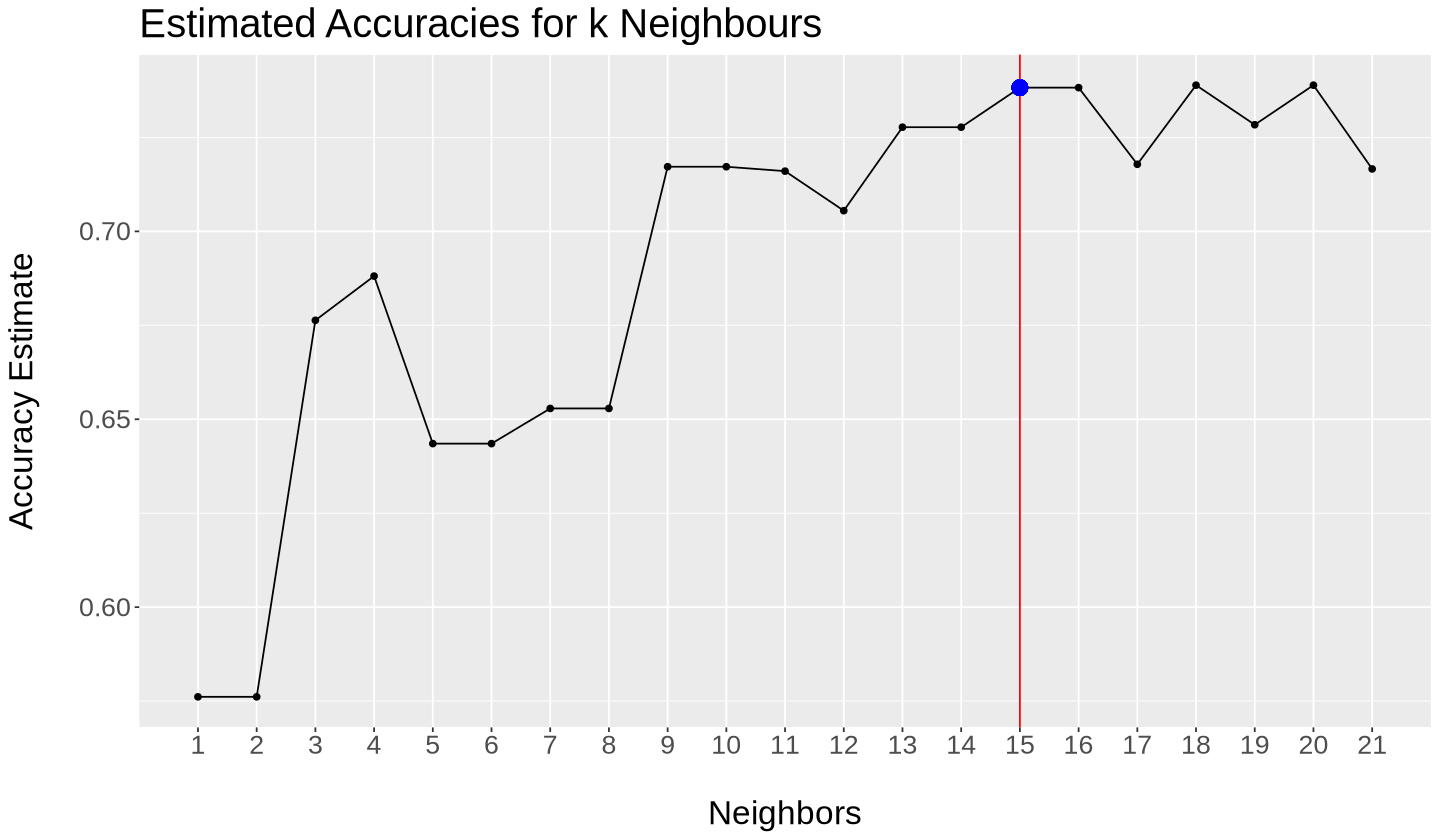

In [11]:
set.seed(1)
ps_recipe <- recipe(subscribe ~ experience + Age + number_of_sessions, data = ps_train) |> 
    step_scale(number_of_sessions, Age) |> 
    step_center(number_of_sessions, Age)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification")

ps_vfold <- vfold_cv(ps_train, v = 5, strata = subscribe)
gridvals <- tibble(neighbors = seq(1, 21))

ps_results <- workflow() |> 
    add_recipe(ps_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = ps_vfold, grid = gridvals) |> 
    collect_metrics() |> 
    filter(.metric == "accuracy")

options(repr.plot.width = 12, repr.plot.height = 7)

ky <- ps_results |> filter(neighbors == 15) |> select(mean) |> pull()

cross_val_plot <- ps_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    geom_vline(xintercept = 15, colour = "red") +
    geom_point(aes(x=15, y= ky), size = 4, colour = "blue") +
    labs(x = "\nNeighbors",
         y = "Accuracy Estimate\n",
         title = "Estimated Accuracies for k Neighbours") +
    scale_x_continuous(limits = c(1, 21), breaks = seq(1, 21), minor_breaks = seq(1, 21, 1)) +
    theme(text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))

cross_val_plot

.metric,.estimate
<chr>,<dbl>
accuracy,0.7096774


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


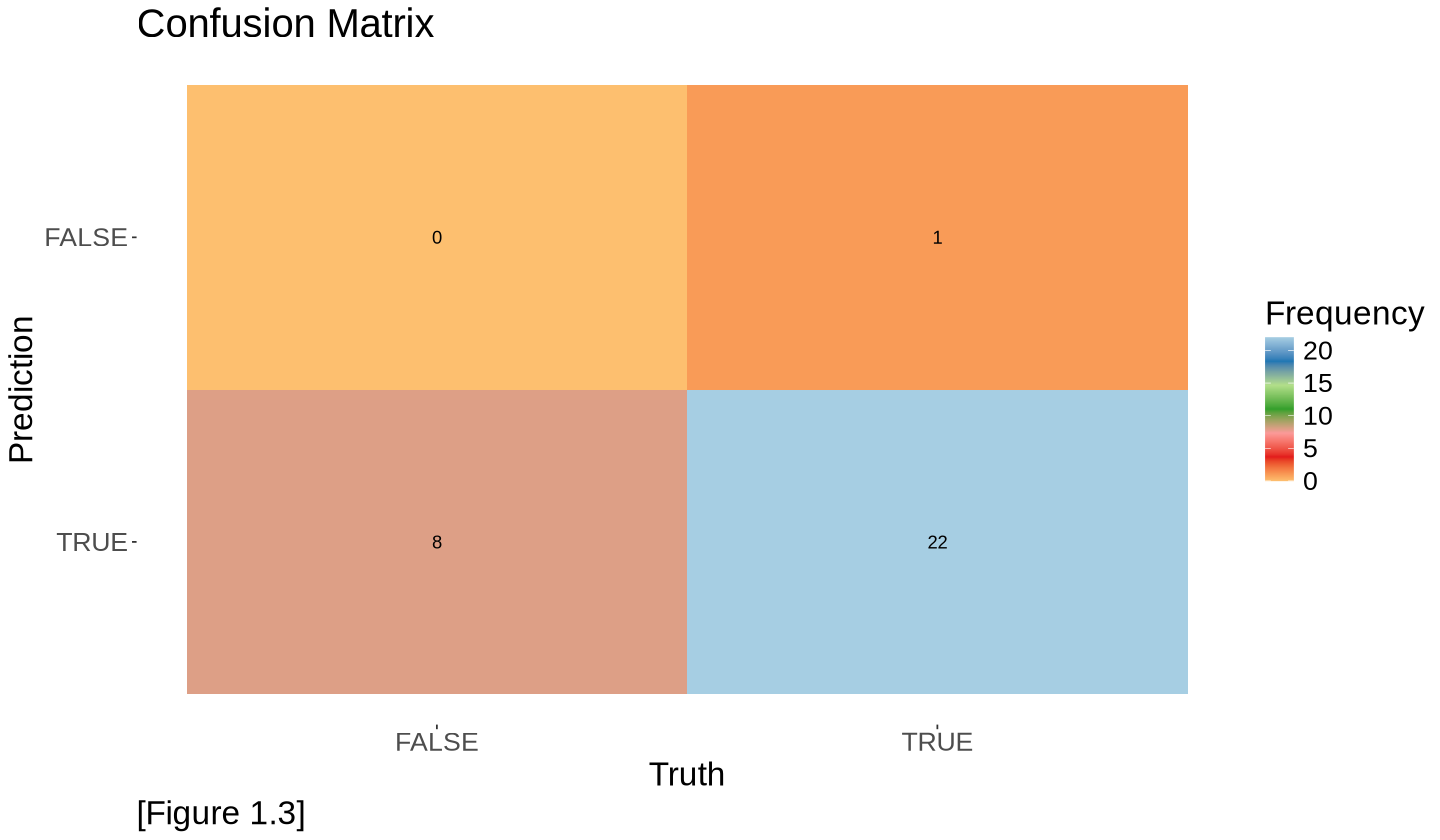

In [12]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
    set_engine("kknn") |>
    set_mode("classification")

ps_fit <- workflow() |>
  add_recipe(ps_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = ps_train)

ps_predictions <- predict(ps_fit, ps_test) |> 
    bind_cols(ps_test)

ps_acc <- ps_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
ps_acc

ps_cm <- ps_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

autoplot(ps_cm, type = "heatmap") +
    scale_fill_distiller(palette = "Paired", name = "Frequency") + #color blind friendly
    labs(title = "Confusion Matrix", caption = "[Figure 1.3]") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))